# Process responses

A Notebook to process the responses file and create a json file with one dataset and a pair of ranked specs.

In [1]:
import pandas as pd
import numpy as np
import json
import itertools
import scipy.stats as stats
import math
from draco.learn.helper import contingency_table
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
data = pd.read_csv('responses.csv', low_memory=False)

# multiple entropy by log_2(20) to remove the normalization that was performed
data['Q1_entropy'] = data['Q1_entropy'] * math.log2(20)
data['Q2_entropy'] = data['Q2_entropy'] * math.log2(20)

In [3]:
np.unique(data.taskGroup)

array(['compareAggregatedValue', 'compareValue', 'findExtremum',
       'readValue'], dtype=object)

In [4]:
# rename tasks into our taxonomy
data.taskGroup.replace({
    'readValue': 'value',
    'compareValue': 'value',
    'findExtremum': 'summary',
    'compareAggregatedValue': 'summary'
}, inplace=True)

In [5]:
np.unique(data.taskGroup)

array(['summary', 'value'], dtype=object)

In [6]:
len(data)

184320

In [7]:
# put entropy into quantiles (low, high)

data['Q1_entropy_group'] = pd.qcut(data['Q1_entropy'], 2, labels=["L", "H"])
data['Q2_entropy_group'] = pd.qcut(data['Q2_entropy'], 2, labels=["L", 'H'])

# entropy_cut = 0.3
# data.loc[normalized['Q1_entropy'] > entropy_cut, 'Q1_entropy_group'] = 'H'
# data.loc[normalized['Q1_entropy'] <= entropy_cut, 'Q1_entropy_group'] = 'L'
# data.loc[normalized['Q2_entropy'] > entropy_cut, 'Q2_entropy_group'] = 'H'
# data.loc[normalized['Q2_entropy'] <= entropy_cut, 'Q2_entropy_group'] = 'L'

In [8]:
gb = data.groupby([
    'taskGroup', 'cardinality', 'nPerCategory',
    'Q1_channel', 'Q2_channel', 'name_channel',
    'Q1_entropy_class', 'Q2_entropy_class',
#    'Q1_entropy_group', 'Q2_entropy_group'
])

In [9]:
row = data.iloc[0]
# row

In [10]:
def parse(group):
    cardinality = int(group['cardinality'].iloc[0])
    num_rows = cardinality * int(group['nPerCategory'].iloc[0])

    q1_entropy = group['Q1_entropy'].mean();
    q2_entropy = group['Q2_entropy'].mean();
    
    Q1_entropy_class = group['Q1_entropy_class'].iloc[0];
    Q2_entropy_class = group['Q2_entropy_class'].iloc[0];
    
    # we can identify the same dataset with the key
    data_key = f'{num_rows},{Q1_entropy_class},{Q2_entropy_class}'
    
    task = group['taskGroup'].iloc[0]
    
    fields = [
        {'name': 'n', 'type': 'string', 'entropy': 1, 'cardinality': cardinality, 'interesting': task == 'summary'},
        {'name': 'q1', 'type': 'number', 'entropy': round(q1_entropy, 4), 'cardinality': num_rows, 'interesting': True},
        {'name': 'q2', 'type': 'number', 'entropy': round(q2_entropy, 4), 'cardinality': num_rows}
    ]

    enc = {}

    enc[group['Q1_channel'].iloc[0]] = {'field': 'q1', 'type': 'quantitative', 'scale': {'zero': True}}
    enc[group['Q2_channel'].iloc[0]] = {'field': 'q2', 'type': 'quantitative', 'scale': {'zero': True}}
    enc[group['name_channel'].iloc[0]] = {'field': 'n', 'type': 'nominal'}

    spec = {
        'mark': 'point',
        'encoding': enc
    }

    return {
        'data_key': data_key,
        'fields': fields,
        'num_rows': num_rows,
        'task': task,
        'spec': spec,
        'isCorrect': group['isCorrect'],
        'completionTime': group['completionTime'],
    }

In [11]:
specs = pd.DataFrame(columns=['data_key', 'fields', 'num_rows', 'task', 'spec',
                              'isCorrect', 'completionTime'])
for name, group in gb:
    parsed = parse(group)
    specs = specs.append(parsed, ignore_index=True)
    
print('Number of groups', len(specs))

Number of groups 576


In [12]:
grouped_specs = specs.groupby(['data_key', 'num_rows', 'task'])

print(len(grouped_specs))

48


In [13]:
grouped_specs.num_rows.describe()
# specs[:10]

count  unique  top  freq
data_key num_rows task                             
30,H,H   30       summary     12       1   30    12
                  value       12       1   30    12
30,H,L   30       summary     12       1   30    12
                  value       12       1   30    12
30,L,H   30       summary     12       1   30    12
                  value       12       1   30    12
30,L,L   30       summary     12       1   30    12
                  value       12       1   30    12
300,H,H  300      summary     12       1  300    12
                  value       12       1  300    12
300,H,L  300      summary     12       1  300    12
                  value       12       1  300    12
300,L,H  300      summary     12       1  300    12
                  value       12       1  300    12
300,L,L  300      summary     12       1  300    12
                  value       12       1  300    12
60,H,H   60       summary     12       1   60    12
                  value       12       1   60    12
60,H,L   60       summary     12       1   60    12
                  value       12       1   60    12
60,L,H   60       summary     12       1   60    12
                  value       12       1   60    12
60,L,L   60       summary     12       1   60    12
                  value       12       1   60    12
600,H,H  600      summary     12       1  600    12
                  value       12       1  600    12
600,H,L  600      summary     12       1  600    12
                  value       12       1  600    12
600,L,H  600      summary     12       1  600    12
                  value       12       1  600    12
600,L,L  600      summary     12       1  600    12
                  value       12       1  600    12
9,H,H    9        summary     12       1    9    12
                  value       12       1    9    12
9,H,L    9        summary     12       1    9    12
                  value       12       1    9    12
9,L,H    9        summary     12       1    9    12
                  value       12       1    9    12
9,L,L    9        summary     12       1    9    12
                  value       12       1    9    12
90,H,H   90       summary     12       1   90    12
                  value       12       1   90    12
90,H,L   90       summary     12       1   90    12
                  value       12       1   90    12
90,L,H   90       summary     12       1   90    12
                  value       12       1   90    12
90,L,L   90       summary     12       1   90    12
                  value       12       1   90    12

In [14]:
training = []

for name, group in grouped_specs:
    for fst, snd in itertools.combinations(range(len(group)), 2):
        first = group.iloc[fst]
        second = group.iloc[snd]
        
        # Run Fisher's test with unpaired data
        # https://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.stats.fisher_exact.html
        ct = contingency_table(first.isCorrect, second.isCorrect)        
        oddsratio, p = stats.fisher_exact(ct)
        
#         if p > .01:
#             # run Welch's t-test: https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.ttest_ind.html
#             t, p = stats.ttest_ind(negative.completionTime, positive.completionTime, equal_var=False)
        if p <= .01:
            first_better = np.mean(first.isCorrect) > np.mean(second.isCorrect)
        
            training.append({
                'fields': group.iloc[0]['fields'],
                'num_rows': group.iloc[0]['num_rows'],
                'task': group.iloc[0]['task'],
                'negative': second.spec if first_better else first.spec,
                'positive': first.spec if first_better else second.spec,
                'pvalue': round(p, 6)
            })

In [15]:
len(training)

1152

In [16]:
training[0]

{'fields': [{'cardinality': 10,
   'entropy': 1,
   'interesting': True,
   'name': 'n',
   'type': 'string'},
  {'cardinality': 30,
   'entropy': 3.8428,
   'interesting': True,
   'name': 'q1',
   'type': 'number'},
  {'cardinality': 30, 'entropy': 3.9115, 'name': 'q2', 'type': 'number'}],
 'negative': {'encoding': {'color': {'field': 'q1',
    'scale': {'zero': True},
    'type': 'quantitative'},
   'x': {'field': 'q2', 'scale': {'zero': True}, 'type': 'quantitative'},
   'y': {'field': 'n', 'type': 'nominal'}},
  'mark': 'point'},
 'num_rows': 30,
 'positive': {'encoding': {'size': {'field': 'q1',
    'scale': {'zero': True},
    'type': 'quantitative'},
   'x': {'field': 'q2', 'scale': {'zero': True}, 'type': 'quantitative'},
   'y': {'field': 'n', 'type': 'nominal'}},
  'mark': 'point'},
 'pvalue': 0.002352,
 'task': 'summary'}

In [17]:
with open('../data/training/younghoon.json', 'w') as f:
    json.dump({'$schema': './schema.json', 'source': 'younghoon', 'data': training}, f, indent=2)

# Figure out what are the preferences in the data

In [18]:
def to_name(spec):
    enc = spec['encoding']
    
    d = {}
    
    d[enc['x']['field']] = 'x'
    d[enc['y']['field']] = 'y'
    
    if 'color' in enc:
        color = enc['color']['field']
        d[color] = 'color'
    if 'size' in enc:
        size = enc['size']['field']
        d[size] = 'size'
    if 'row' in enc:
        row = enc['row']['field']
        d[row] = 'row'

    return f'Q1:{d["q1"]}, Q2:{d["q2"]}, N:{d["n"]}'

In [19]:
order = defaultdict(lambda: defaultdict(nx.DiGraph))

per_task = defaultdict(nx.DiGraph)

for name, group in grouped_specs:
    for fst, snd in itertools.combinations(range(len(group)), 2):
        first = group.iloc[fst]
        second = group.iloc[snd]
        
        ct = contingency_table(first.isCorrect, second.isCorrect)        
        oddsratio, p = stats.fisher_exact(ct)
        
        task = group.iloc[0]['task']
        data_key = group.iloc[0]['data_key']
        
        g = order[task][data_key]
        
        g.add_node(to_name(first.spec))
        g.add_node(to_name(second.spec))
        
        if p <= .01:
            first_better = np.mean(first.isCorrect) > np.mean(second.isCorrect)

            negative = second.spec if first_better else first.spec
            positive = first.spec if first_better else second.spec
                    
            g.add_edge(to_name(negative), to_name(positive))
            
            per_task[task].add_edge(to_name(negative), to_name(positive))

In [35]:
# find all nodes that don't have a preferred visualization: these are the optimal ones

data_keys = order['value'].keys()

perfects_yh = defaultdict(lambda: defaultdict(set))

for task in ['value', 'summary']:
    for data_key in data_keys:
        G = order[task][data_key]
        nodes = G.nodes
        edges = G.out_edges
        imperfect_nodes = set(map(lambda e: e[0], edges))
        perfects_yh[task][data_key] = set(nodes) - imperfect_nodes

perfects_yh = dict(perfects_yh)
%store perfects_yh  # store so we can load it later

Stored 'perfects_yh' (dict)


In [21]:
nodes = list(order['summary']['30,L,L'].nodes)
nodes.sort()
colors = list(map(lambda x: mpl.colors.rgb2hex(plt.get_cmap('Paired')(x)), range(len(nodes))))
color_dict = dict(zip(nodes, colors))

/usr/local/anaconda3/envs/asp/lib/python3.6/subprocess.py:766: ResourceWarning: subprocess 40650 is still running
/usr/local/anaconda3/envs/asp/lib/python3.6/subprocess.py:766: ResourceWarning: subprocess 40651 is still running
/usr/local/anaconda3/envs/asp/lib/python3.6/subprocess.py:766: ResourceWarning: subprocess 40652 is still running
/usr/local/anaconda3/envs/asp/lib/python3.6/subprocess.py:766: ResourceWarning: subprocess 40653 is still running


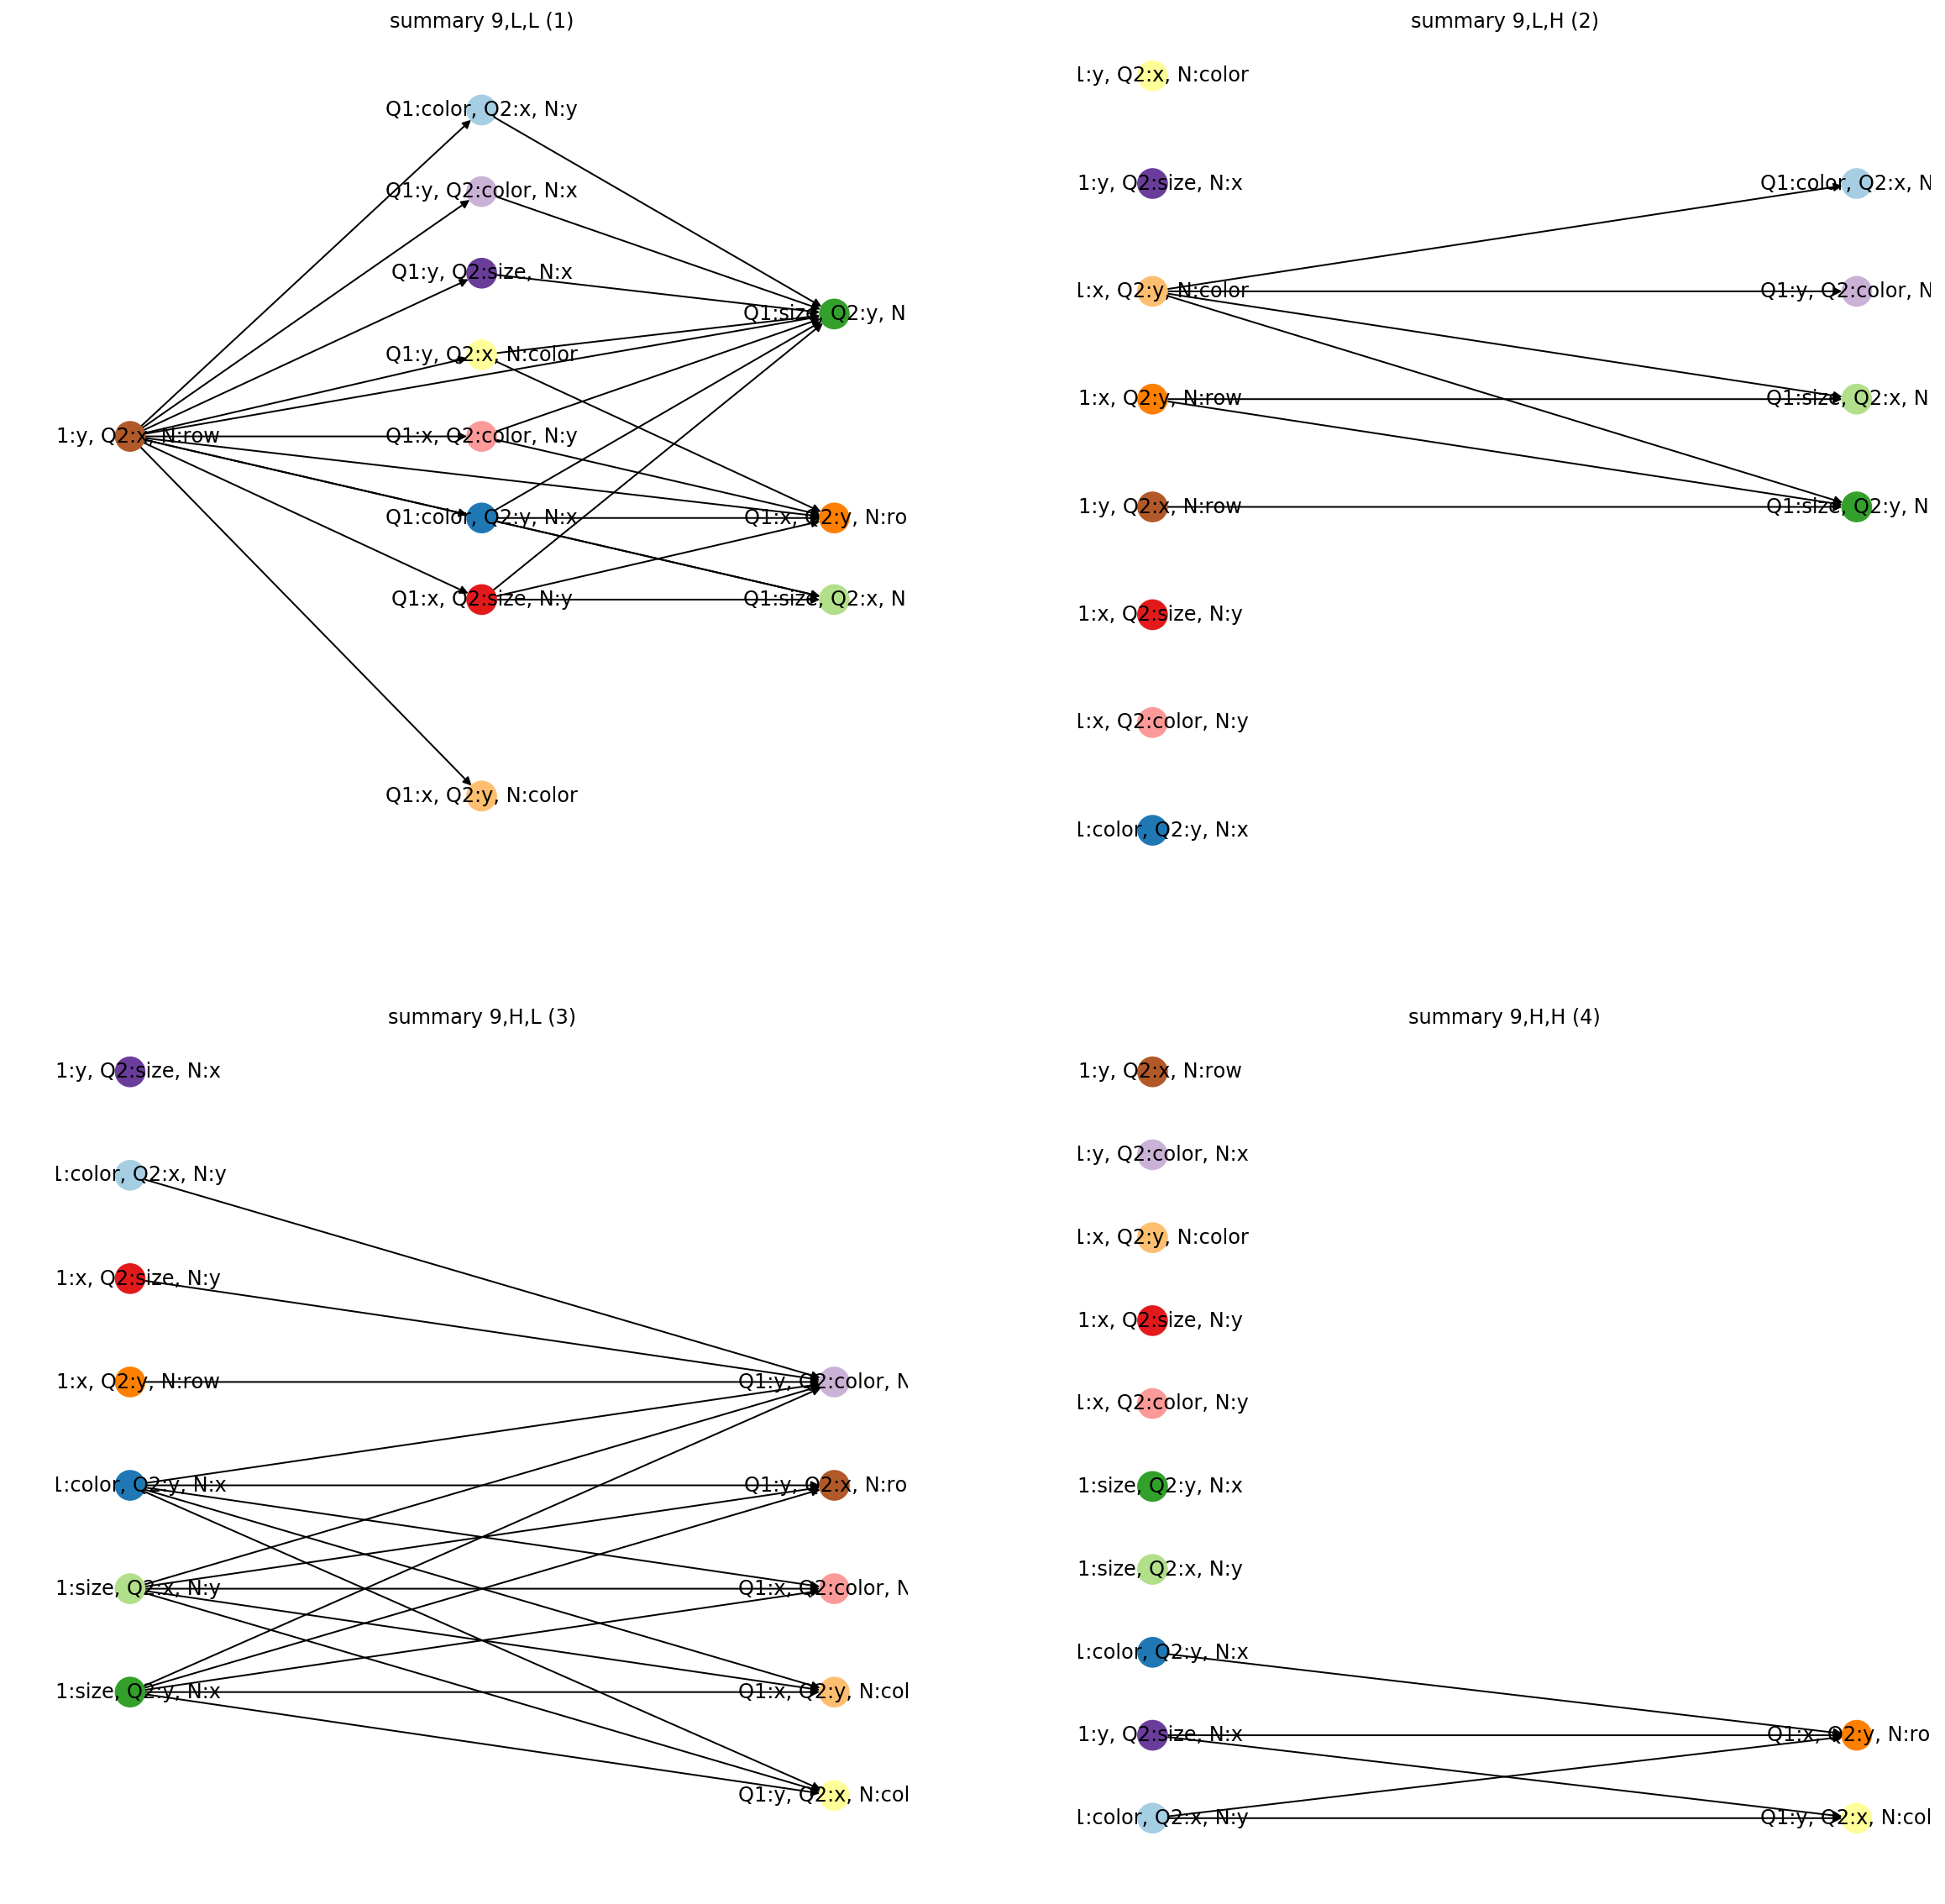

In [22]:
task = 'summary'
num_rows = 9

f = plt.figure(figsize=(20,20))

def plot(task, size, e1, e2, idx):
    ax = f.add_subplot(2,2,idx)
    t = f'{size},{e1},{e2}'
    G = order[task][t]
    pos = nx.nx_agraph.graphviz_layout(G, prog='dot', args="-Grankdir=LR")
    nx.draw(G, pos=pos, with_labels=True, ax=ax, node_color=colors)
    ax.set_title(f'{task} {t} ({idx})')
    
plot(task, num_rows, 'L', 'L', 1)
plot(task, num_rows, 'L', 'H', 2)
plot(task, num_rows, 'H', 'L', 3)
plot(task, num_rows, 'H', 'H', 4)

/usr/local/anaconda3/envs/asp/lib/python3.6/subprocess.py:766: ResourceWarning: subprocess 40658 is still running
/usr/local/anaconda3/envs/asp/lib/python3.6/subprocess.py:766: ResourceWarning: subprocess 40659 is still running


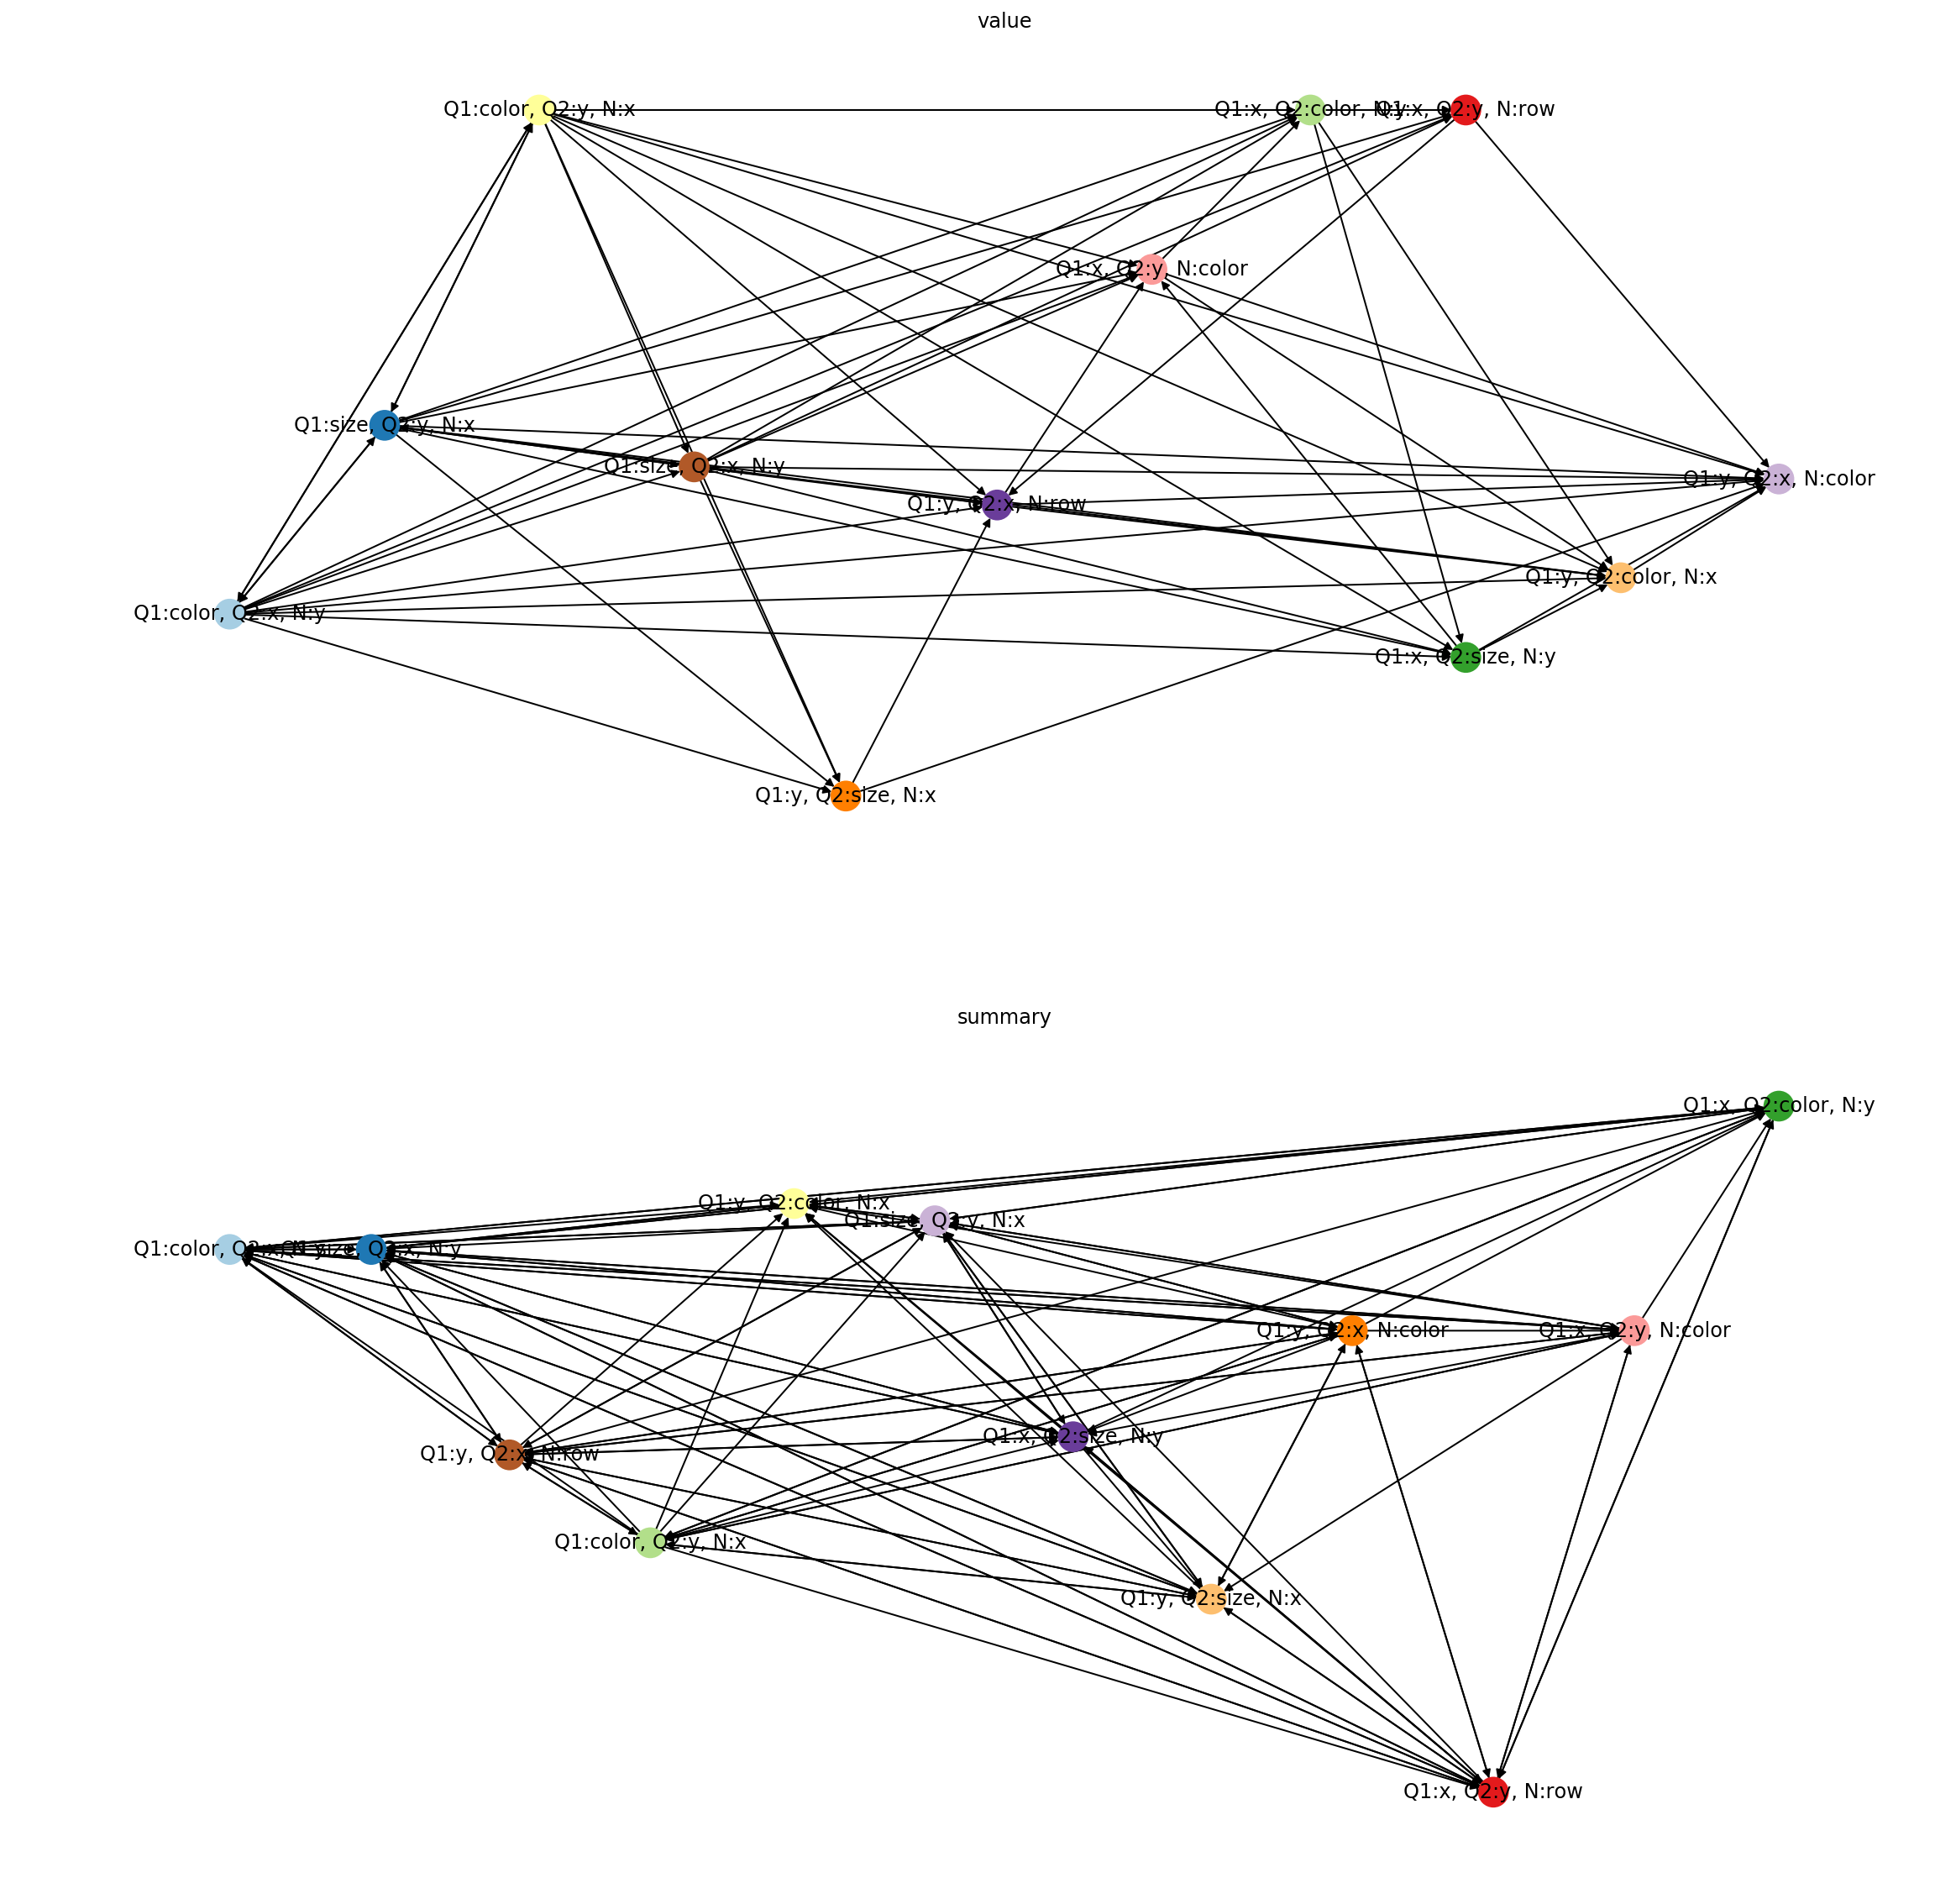

In [23]:
f = plt.figure(figsize=(20,20))

def plot(task, idx):
    ax = f.add_subplot(2,1,idx)
    G = per_task[task]
    pos = nx.nx_agraph.graphviz_layout(G, prog='dot', args="-Grankdir=LR")
    nx.draw(G, pos=pos, with_labels=True, ax=ax, node_color=colors)
    ax.set_title(f'{task}')
    
plot('value', 1)
plot('summary', 2)